# HW 5 Task 3.1

In [0]:
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import pandas as pd
from keras.models import Model, Sequential
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dense, Activation, Dropout, Flatten,BatchNormalization, Conv2D, MaxPooling2D
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

### Read in all images with class 0

In [0]:
img_0 = np.array([cv2.resize(cv2.imread(file), (50,50), interpolation=cv2.INTER_CUBIC) for file in glob.glob("/content/*/0/*.png")])

In [3]:
img_0.shape

(198738, 50, 50, 3)

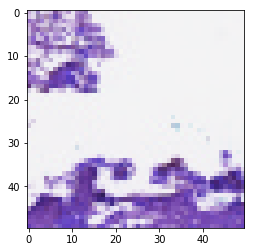

In [4]:
plt.imshow(img_0[0])

### Read in all images with class 1

In [0]:
img_1 = np.array([cv2.resize(cv2.imread(file), (50,50), interpolation=cv2.INTER_CUBIC) for file in glob.glob("/content/*/1/*.png")])

In [6]:
img_1.shape

(78786, 50, 50, 3)

### Combine the data and set its labels y according to the class

In [0]:
y = []
X = []

In [0]:
y = np.concatenate((np.repeat(0,img_0.shape[0]),np.repeat(1,img_1.shape[0])))

In [0]:
X = np.concatenate((img_0,img_1))

In [10]:
X.shape

(277524, 50, 50, 3)

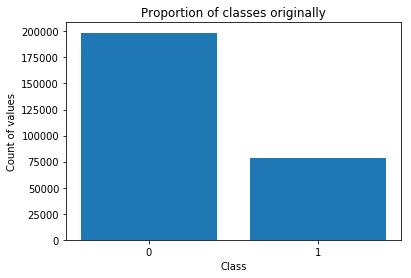

In [11]:
plt.bar(pd.Series(y).value_counts().keys(), pd.Series(y).value_counts().values)
plt.xticks([0,1])
plt.title('Proportion of classes originally')
plt.xlabel('Class')
plt.ylabel('Count of values')
plt.show()

#### We can see the the data is imbalanced - so we perform random undersampling to balance it. As X has 4 dimensions, we first flatten it and then undersample and then reshape it again

In [0]:
X_flat = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [13]:
X_flat.shape

(277524, 7500)

In [0]:
rus = RandomUnderSampler(ratio='auto', random_state=0)
X_us, y_us = rus.fit_sample(X_flat, y)

In [0]:
X_us = X_us.reshape((X_us.shape[0], X.shape[1], X.shape[2], X.shape[3]))

Observe that images are still intact

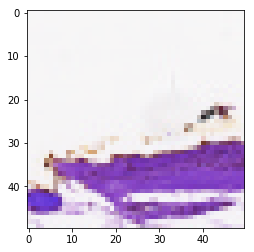

In [16]:
plt.imshow(X_us[35])

In [17]:
pd.Series(y_us).value_counts()

1    78786
0    78786
dtype: int64

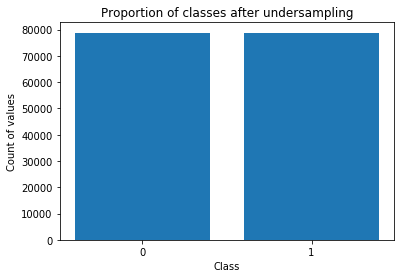

In [18]:
plt.bar(pd.Series(y_us).value_counts().keys(), pd.Series(y_us).value_counts().values)
plt.xticks([0,1])
plt.title('Proportion of classes after undersampling')
plt.xlabel('Class')
plt.ylabel('Count of values')
plt.show()

#### Now our data is balanced

### Take a subsample of the balanced dataset (20% of it) as the total data is too large to train a network on and it causes the server to crash

In [0]:
X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(X_us, y_us, train_size=0.05, test_size=0.8, random_state=0)

### Split the subsampled data into training and test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, random_state=0)

In [103]:
X_train.shape

(5908, 50, 50, 3)

In [104]:
X_test.shape

(1970, 50, 50, 3)

### One hot encode y

In [0]:
dummy_y_train = to_categorical(y_train, num_classes=2)
dummy_y_test = to_categorical(y_test, num_classes=2)

### Divide X train and test by 255 to ensure values are between 0 and 1

In [0]:
X_train = X_train/255

In [0]:
X_test = X_test/255

### Create a convolutional NN with 6 hidden layers (3 convolution and 3 max pooling)

In [0]:
cnn_small_bn = Sequential()
cnn_small_bn.add(Conv2D(8, kernel_size=(3, 3),
                 input_shape=(50,50,3)))
cnn_small_bn.add(Activation("relu"))
cnn_small_bn.add(BatchNormalization())
cnn_small_bn.add(MaxPooling2D(pool_size=(2, 2)))
cnn_small_bn.add(Conv2D(8, (3, 3)))
cnn_small_bn.add(Activation("relu"))
cnn_small_bn.add(BatchNormalization())
cnn_small_bn.add(MaxPooling2D(pool_size=(2, 2)))
cnn_small_bn.add(Dropout(0.5))
cnn_small_bn.add(Conv2D(8, (3, 3)))
cnn_small_bn.add(Activation("relu"))
cnn_small_bn.add(BatchNormalization())
cnn_small_bn.add(MaxPooling2D(pool_size=(2, 2)))
cnn_small_bn.add(Dropout(0.5))
cnn_small_bn.add(Flatten())
cnn_small_bn.add(Dense(2, activation='softmax'))

In [0]:
cnn_small_bn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [147]:
fitted = cnn_small_bn.fit(X_train, dummy_y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 4726 samples, validate on 1182 samples
Epoch 1/20
4726/4726 [==============================] - 6s 1ms/step - loss: 1.2003 - acc: 0.6039 - val_loss: 1.1189 - val_acc: 0.5694
Epoch 2/20
4726/4726 [==============================] - 1s 129us/step - loss: 0.8213 - acc: 0.7084 - val_loss: 0.6834 - val_acc: 0.7513
Epoch 3/20
4726/4726 [==============================] - 1s 133us/step - loss: 0.7534 - acc: 0.7266 - val_loss: 0.8159 - val_acc: 0.6624
Epoch 4/20
4726/4726 [==============================] - 1s 138us/step - loss: 0.6658 - acc: 0.7440 - val_loss: 0.5380 - val_acc: 0.7547
Epoch 5/20
4726/4726 [==============================] - 1s 137us/step - loss: 0.6199 - acc: 0.7495 - val_loss: 0.6592 - val_acc: 0.7276
Epoch 6/20
4726/4726 [==============================] - 1s 135us/step - loss: 0.5868 - acc: 0.7598 - val_loss: 0.5918 - val_acc: 0.7352
Epoch 7/20
4726/4726 [==============================] - 1s 141us/step - loss: 0.5429 - acc: 0.7725 - val_loss: 0.5092 - val_acc: 0.7648
Ep

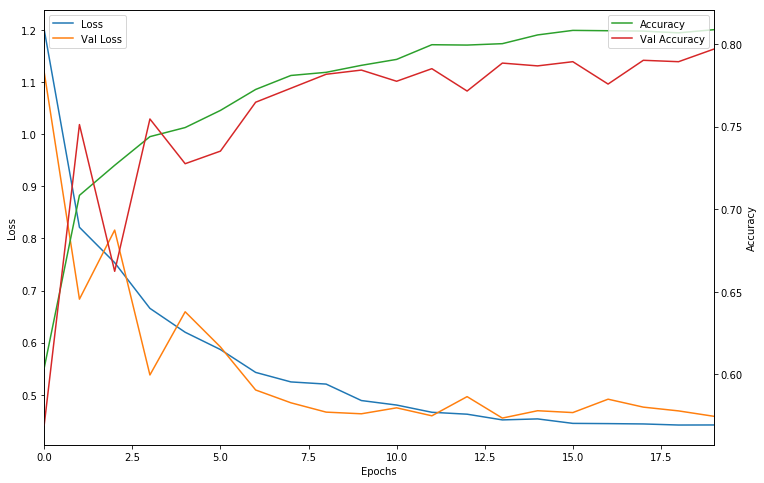

In [148]:
df = pd.DataFrame(fitted.history)
plt.figure(figsize=(12,8))
plt.xlabel('Epochs')

ax1 = df['loss'].plot(label='Loss')
ax1 = df['val_loss'].plot(label='Val Loss')
ax2 = df['acc'].plot(secondary_y=True, label='Accuracy')
ax2 = df['val_acc'].plot(secondary_y=True, label='Val Accuracy')

ax1.set_ylabel('Loss')
# ax1.set_yticks(np.arange(0,2,0.1))
ax2.set_ylabel('Accuracy')
# ax2.set_yticks(np.arange(0,1,0.1))
ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

We can see that the training accuracy is 0.80 and validation accuracy is 0.79